In [1]:
import numpy as np
import pandas as pd
from scipy import signal as sig
import h5py as h5

import matplotlib.pyplot as plt
import matplotlib as mpl

from bokeh.plotting import figure, show, save
from bokeh.io import output_notebook, output_file, reset_output
from bokeh.layouts import gridplot, row, column
output_notebook()

Loading BokehJS ...

In [2]:
def read_hdf(fileName, opts=[]):
    data = pd.DataFrame()
    if len(opts) == 0:
        for chanName in h5.File(fileName, "r").keys():
            data[chanName] = h5.File(fileName, "r")[chanName]
    else:
        for chanName in opts:
            data[chanName] = h5.File(fileName, "r")[chanName]
    return data


In [3]:
runname = 'p5607'
SAVE=1;

chans = ['time', 'effNS', 'int disp', 'norm disp']

data = read_hdf(runname+'_r.hdf5', chans)

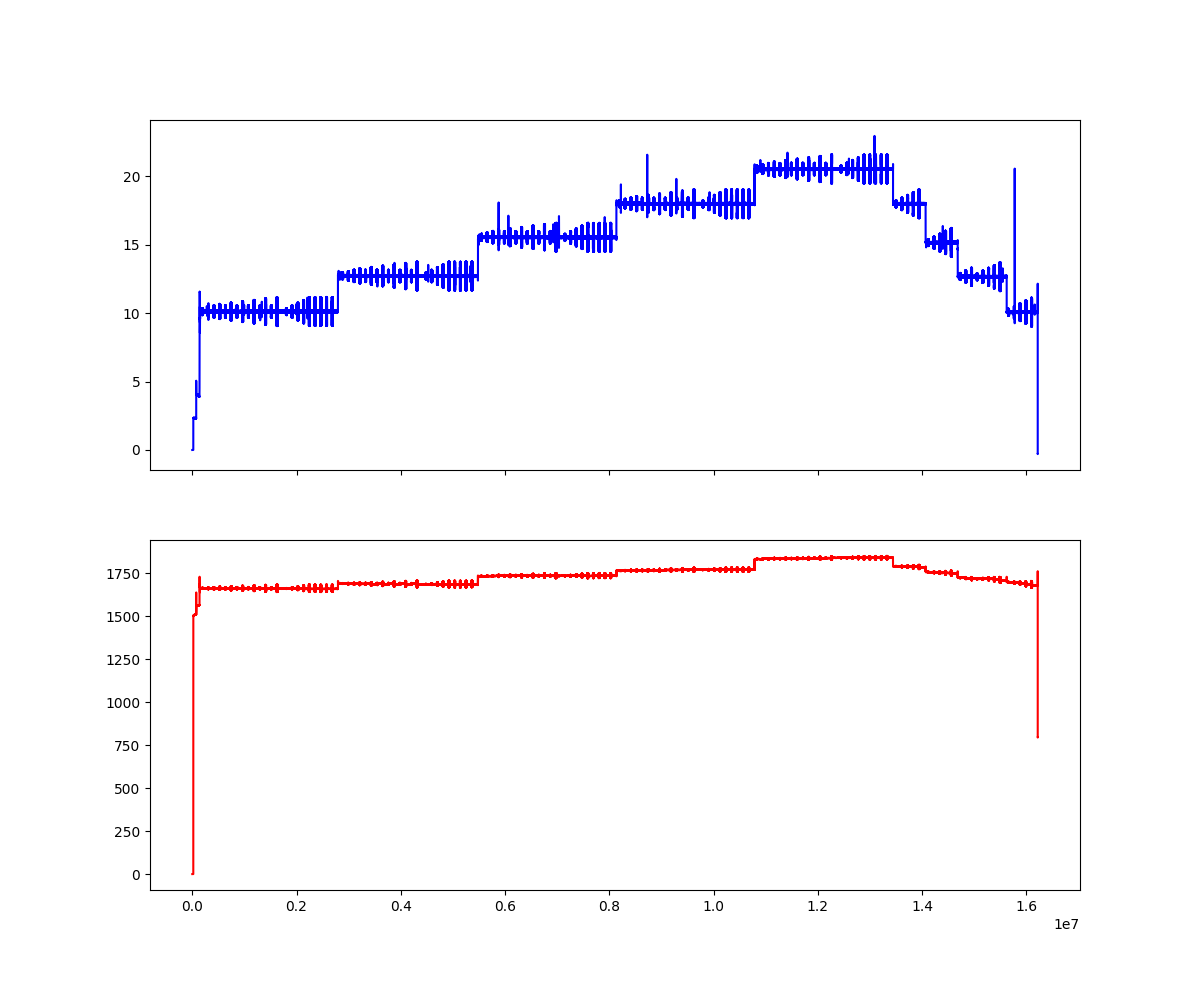

In [4]:
%matplotlib widget
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
axs[0].plot(data['effNS'], color='blue')
axs[1].plot(data['int disp'], color='red')

plt.show()

In [5]:
idx_original_thickness = 19644

In [6]:
## Low pass filter intDisp whenever recording rate is 1000Hz;
sampFreq = 1/np.diff(data['time'])
sampFreq = np.append(sampFreq, 1) # add one sample at 1Hz at the end so that fs has the same size as other mechanical data.

# idxfs1000only = np.where[sampFreq > 900]
idxfs100only = np.where(np.logical_and(sampFreq > 90, sampFreq < 110));
intDisp100only = data['int disp'].to_numpy()[idxfs100only];

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = fs/2
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = sig.butter(order, normal_cutoff, btype='low', analog=False)
    y = sig.filtfilt(b, a, data)
    return y

In [7]:
fs = 100
freqfilter = 12
order = 16

intDisp100onlyLPF = butter_lowpass_filter(intDisp100only, freqfilter, fs, order)

intDispLPF = data['int disp'].to_numpy()
intDispLPF[idxfs100only] = intDisp100onlyLPF

# PLOT TO CHECK FILTERING
# fig21 = figure(title='Normal & Internal Displacement', tools='pan,box_zoom,undo,hover,crosshair') 
# fig21.line(Time[472213:826772], effNS[472213:826772], line_width=1.5, line_color="crimson")
# fig21.yaxis.axis_label = 'effNS (MPa)'

# fig22 = figure(x_range=fig21.x_range, tools='pan,box_zoom,undo,save,hover,crosshair')
# fig22.line(Time[472213:826772], intDisp[472213:826772], line_width=1.5, line_color="dodgerblue")
# fig22.line(Time[472213:826772], intDispLPF[472213:826772], line_width=1.5, line_color="black")
# fig22.yaxis.axis_label = 'Int. DCDT (um)'

# fig2 = gridplot([fig21, fig22], ncols=1, plot_width=800, plot_height=250)
# show(fig2)

In [8]:
## plot thickness and thickness change
InitTh = 26.15 # mm
Th = InitTh + data['int disp']/1000 - data['int disp'].to_numpy()[idx_original_thickness]/1000;
ThLPF = InitTh + intDispLPF/1000 - intDispLPF[idx_original_thickness]/1000 # low pass filtered
Th[0:idx_original_thickness] = InitTh
ThLPF[0:idx_original_thickness] = InitTh

ThChange = (Th - Th[idx_original_thickness])*1000 # in microns
ThChangeLPF = (ThLPF - ThLPF[idx_original_thickness])*1000 # in microns

In [9]:
# fig31 = figure(title='Normal & Internal Displacement', tools='pan,box_zoom,undo,hover,crosshair') 
# fig31.line(Time[472213:826772], effNS[472213:826772], line_width=1.5, line_color="crimson")
# fig31.yaxis.axis_label = 'effNS (MPa)'

# fig32 = figure(x_range=fig31.x_range, tools='pan,box_zoom,undo,save,hover,crosshair')
# fig32.line(Time[472213:826772], ThLPF[472213:826772], line_width=1.5, line_color="teal")
# fig32.yaxis.axis_label = 'Thickness (mm)'

# fig33 = figure(x_range=fig31.x_range, tools='pan,box_zoom,undo,save,hover,crosshair')
# fig33.line(Time[472213:826772], ThChangeLPF[472213:826772], line_width=1.5, line_color="darkturquoise")
# fig33.yaxis.axis_label = 'Thickness change (um)'

# fig3 = gridplot([fig31, fig32, fig33], ncols=1, plot_width=800, plot_height=250)
# show(fig3)

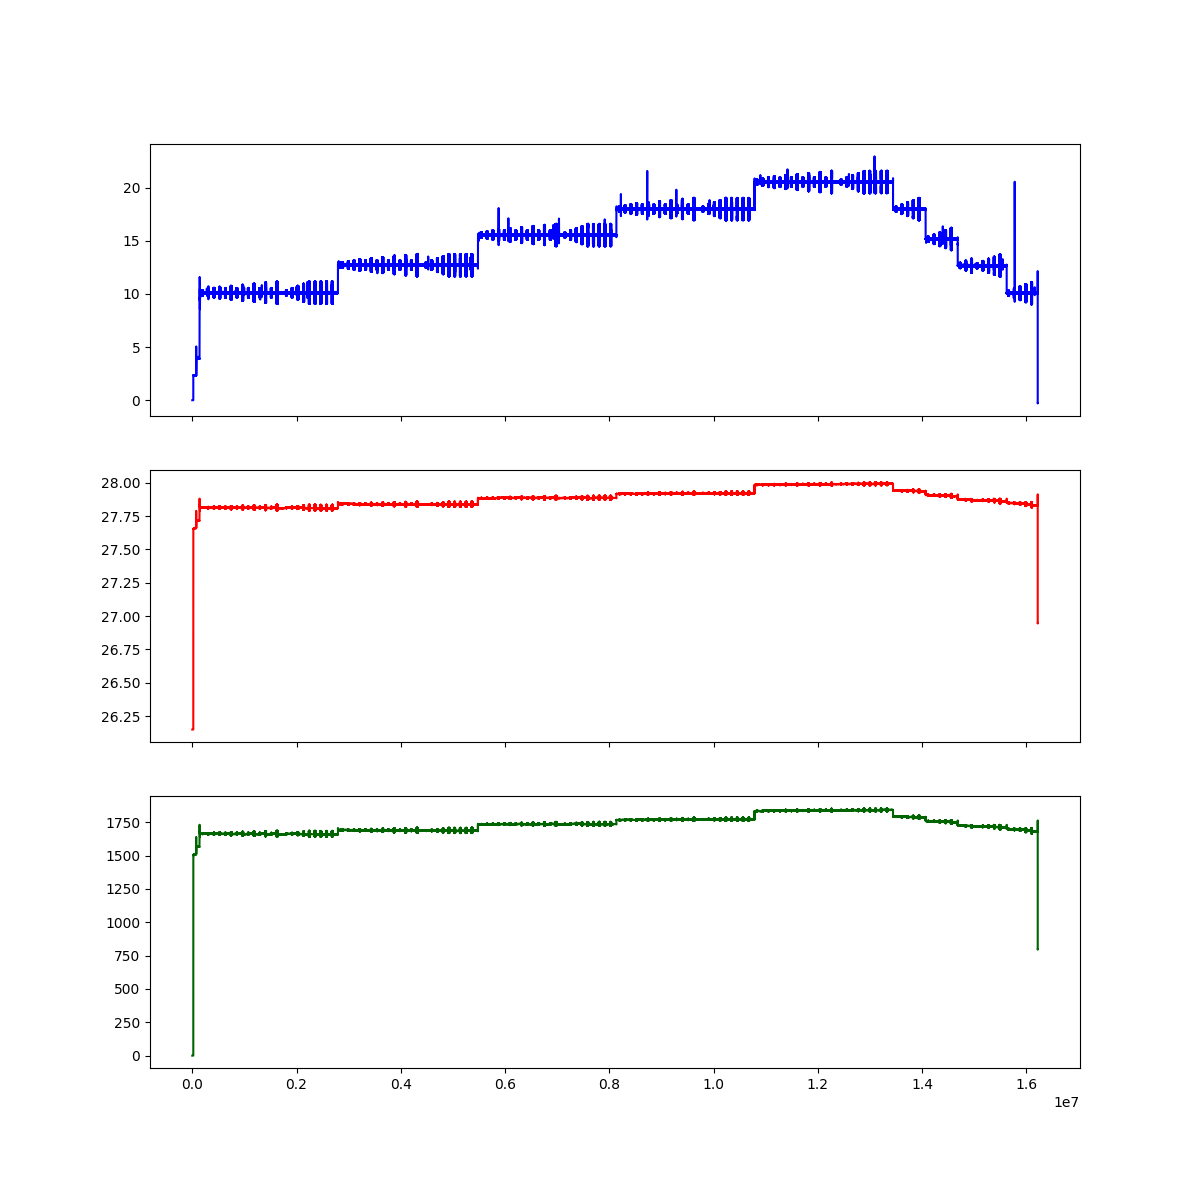

In [10]:
%matplotlib widget
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
axs[0].plot(data['effNS'], color='blue')
axs[1].plot(ThLPF, color='red')
axs[2].plot(ThChangeLPF, color='darkgreen')

plt.show()

In [12]:
if SAVE == 1:
    with h5.File(runname+"_Thickness.hdf5", "w") as f:
        # f.create_dataset('InitTh', data=InitTh)
        # f.create_dataset('idx_original_thickness', data=idx_original_thickness)
        f.create_dataset('Th', data=Th)
        f.create_dataset('ThChange', data=ThChange)
        f.create_dataset('ThLPF', data=ThLPF)
        f.create_dataset('ThChangeLPF', data=ThChangeLPF)
    # with h5.File(runname"_Thickness.hdf5", "w") as f:
    #     f.create_dataset(chanName, data=data[chanName])
#     np.savez_compressed(runname+'_Thickness',InitTh=InitTh,idx_original_thickness=idx_original_thickness,Th=Th,ThChange=ThChange,ThLPF=ThLPF,ThChangeLPF=ThChangeLPF)